In [4]:
pip install neuralforecast

   ---------------------------------------- 0.0/261.0 kB ? eta -:--:--
   --------- ------------------------------ 61.4/261.0 kB 3.2 MB/s eta 0:00:01
   ----------------------- ---------------- 153.6/261.0 kB 2.3 MB/s eta 0:00:01
   ---------------------------------------  256.0/261.0 kB 2.3 MB/s eta 0:00:01
   ---------------------------------------  256.0/261.0 kB 2.3 MB/s eta 0:00:01
   ---------------------------------------- 261.0/261.0 kB 1.2 MB/s eta 0:00:00
   ---------------------------------------- 0.0/209.6 kB ? eta -:--:--
   --------------------- ------------------ 112.6/209.6 kB ? eta -:--:--
   --------------------------------- ------ 174.1/209.6 kB 3.6 MB/s eta 0:00:01
   ------------------------------------- -- 194.6/209.6 kB 3.0 MB/s eta 0:00:01
   ---------------------------------------- 209.6/209.6 kB 1.8 MB/s eta 0:00:00
   ---------------------------------------- 0.0/825.4 kB ? eta -:--:--
   ------ --------------------------------- 143.4/825.4 kB 4.3 MB/s eta 0:0

In [6]:
pip install -U ipywidgets

   ---------------------------------------- 0.0/139.8 kB ? eta -:--:--
   -------------------- ------------------- 71.7/139.8 kB 2.0 MB/s eta 0:00:01
   ----------------------------------- ---- 122.9/139.8 kB 2.4 MB/s eta 0:00:01
   ---------------------------------------- 139.8/139.8 kB 1.0 MB/s eta 0:00:00
   ---------------------------------------- 0.0/216.6 kB ? eta -:--:--
   ----- ---------------------------------- 30.7/216.6 kB ? eta -:--:--
   ----- ---------------------------------- 30.7/216.6 kB ? eta -:--:--
   ---------------------- ----------------- 122.9/216.6 kB 1.0 MB/s eta 0:00:01
   ----------------------------------- ---- 194.6/216.6 kB 1.2 MB/s eta 0:00:01
   ------------------------------------- -- 204.8/216.6 kB 1.1 MB/s eta 0:00:01
   -------------------------------------- 216.6/216.6 kB 946.5 kB/s eta 0:00:00
   ---------------------------------------- 0.0/2.2 MB ? eta -:--:--
   - -------------------------------------- 0.1/2.2 MB 3.0 MB/s eta 0:00:01
   --- ---

In [2]:
pip install torch==2.2.2+cu121 torchvision==0.17.2+cu121 torchaudio==2.2.2+cu121 --index-url https://download.pytorch.org/whl/cu121

Looking in indexes: https://download.pytorch.org/whl/cu121
Note: you may need to restart the kernel to use updated packages.


In [1]:
import torch
print(torch.cuda.is_available())
print(torch.cuda.get_device_name(0))


True
NVIDIA GeForce RTX 3050 Laptop GPU


In [16]:
import pandas as pd

# --- Load Data CSV ---
df = pd.read_csv("BBCA.JK_monthly.csv", parse_dates=['Date'])

In [17]:
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2018-12-31,5200.0,5640.0,5115.0,5635.0,4992.259766,1859122000
1,2019-01-31,5680.0,5750.0,5335.0,5515.0,4885.947266,1493339500
2,2019-02-28,5565.0,5600.0,5425.0,5510.0,4881.518066,790477000
3,2019-03-31,5550.0,5805.0,5450.0,5750.0,5094.143066,989206000
4,2019-04-30,5750.0,5895.0,5140.0,5820.0,5203.292969,1700900500


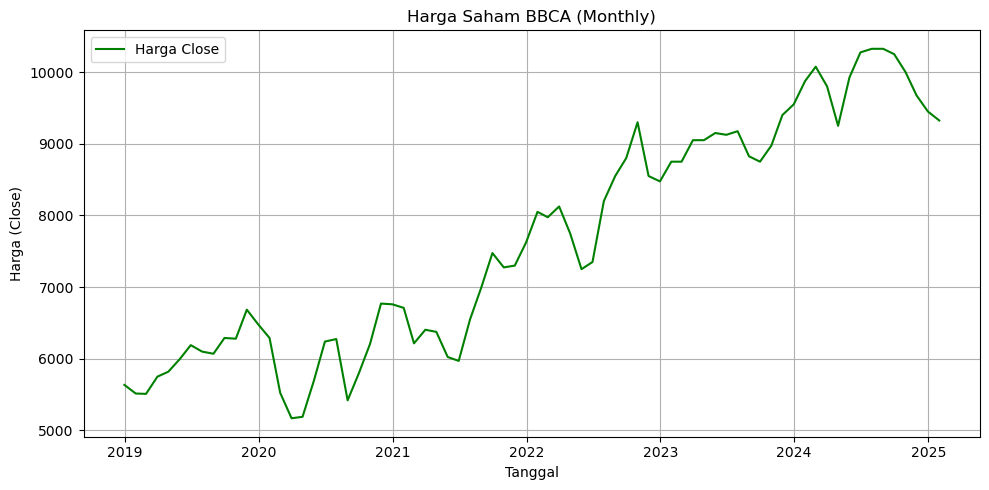

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74 entries, 0 to 73
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Date       74 non-null     datetime64[ns]
 1   Open       74 non-null     float64       
 2   High       74 non-null     float64       
 3   Low        74 non-null     float64       
 4   Close      74 non-null     float64       
 5   Adj Close  74 non-null     float64       
 6   Volume     74 non-null     int64         
dtypes: datetime64[ns](1), float64(5), int64(1)
memory usage: 4.2 KB
None
Date         0
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64


In [18]:
import matplotlib.pyplot as plt

# Plot harga close BBCA dari awal hingga sekarang
plt.figure(figsize=(10, 5))
plt.plot(df['Date'], df['Close'], label='Harga Close', color='green')
plt.title('Harga Saham BBCA (Monthly)')
plt.xlabel('Tanggal')
plt.ylabel('Harga (Close)')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# Cek info data
print(df.info())

# Cek missing value 
print(df.isnull().sum())


In [19]:
# Rename kolom agar sesuai format NeuralForecast
df = df.rename(columns={'Date': 'ds', 'Close': 'y'})

# Tambahkan kolom unique_id 
df['unique_id'] = 'BBCA'

# Tampilkan format akhir
print(df.tail())


           ds     Open     High      Low        y     Adj Close      Volume  \
69 2024-09-30  10400.0  10875.0  10150.0  10250.0  10199.130859  1496034800   
70 2024-10-31  10275.0  10575.0   9800.0  10000.0   9950.372070  1536533300   
71 2024-11-30  10000.0  10425.0   9550.0   9675.0   9675.000000  1354890300   
72 2024-12-31   9650.0   9925.0   9150.0   9450.0   9450.000000  1615499200   
73 2025-01-31   9400.0   9400.0   8825.0   9325.0   9325.000000  1150298100   

   unique_id  
69      BBCA  
70      BBCA  
71      BBCA  
72      BBCA  
73      BBCA  


In [20]:
from neuralforecast import NeuralForecast
from neuralforecast.models import TimesNet

# Konfigurasi model (input_size dan horizon disesuaikan)
model = TimesNet(
    input_size=60,   # gunakan 60 bulan terakhir sebagai input
    h=12             # prediksi 12 bulan ke depan
)

nf = NeuralForecast(models=[model], freq='M')
nf.fit(df)  # df sudah ada dari step sebelumnya

# Prediksi
pred_df = nf.predict()
print(pred_df.head())


Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type          | Params | Mode 
---------------------------------------------------------
0 | loss           | MAE           | 0      | train
1 | padder_train   | ConstantPad1d | 0      | train
2 | scaler         | TemporalNorm  | 0      | train
3 | model          | ModuleList    | 4.7 M  | train
4 | enc_embedding  | DataEmbedding | 192    | train
5 | layer_norm     | LayerNorm     | 128    | train
6 | predict_linear | Linear        | 4.4 K  | train
7 | projection     | Linear        | 65     | train
---------------------------------------------------------
4.7 M     Trainable params
0         Non-trainable params
4.7 M     Total params
18.769    Total estimated model params size (MB)
50        Modules in train mode
0         Modules in eval mode


Sanity Checking: |                                                                               | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

`Trainer.fit` stopped: `max_steps=1000` reached.
C:\Users\USER\anaconda3\Lib\site-packages\utilsforecast\processing.py:384: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  freq = pd.tseries.frequencies.to_offset(freq)
C:\Users\USER\anaconda3\Lib\site-packages\utilsforecast\processing.py:440: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  freq = pd.tseries.frequencies.to_offset(freq)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |                                                                                    | 0/? [00:00<…

  unique_id         ds      TimesNet
0      BBCA 2025-02-28   9663.202148
1      BBCA 2025-03-31  10002.639648
2      BBCA 2025-04-30  10361.042969
3      BBCA 2025-05-31  10653.789062
4      BBCA 2025-06-30  10987.775391


In [7]:
print(pred_df)


   unique_id         ds      TimesNet
0       BBCA 2025-02-28   9663.867188
1       BBCA 2025-03-31   9984.824219
2       BBCA 2025-04-30  10379.201172
3       BBCA 2025-05-31  10674.767578
4       BBCA 2025-06-30  10989.531250
5       BBCA 2025-07-31  11164.765625
6       BBCA 2025-08-31  11153.410156
7       BBCA 2025-09-30  10999.486328
8       BBCA 2025-10-31  10337.275391
9       BBCA 2025-11-30  10386.938477
10      BBCA 2025-12-31  10513.282227
11      BBCA 2026-01-31  10296.665039


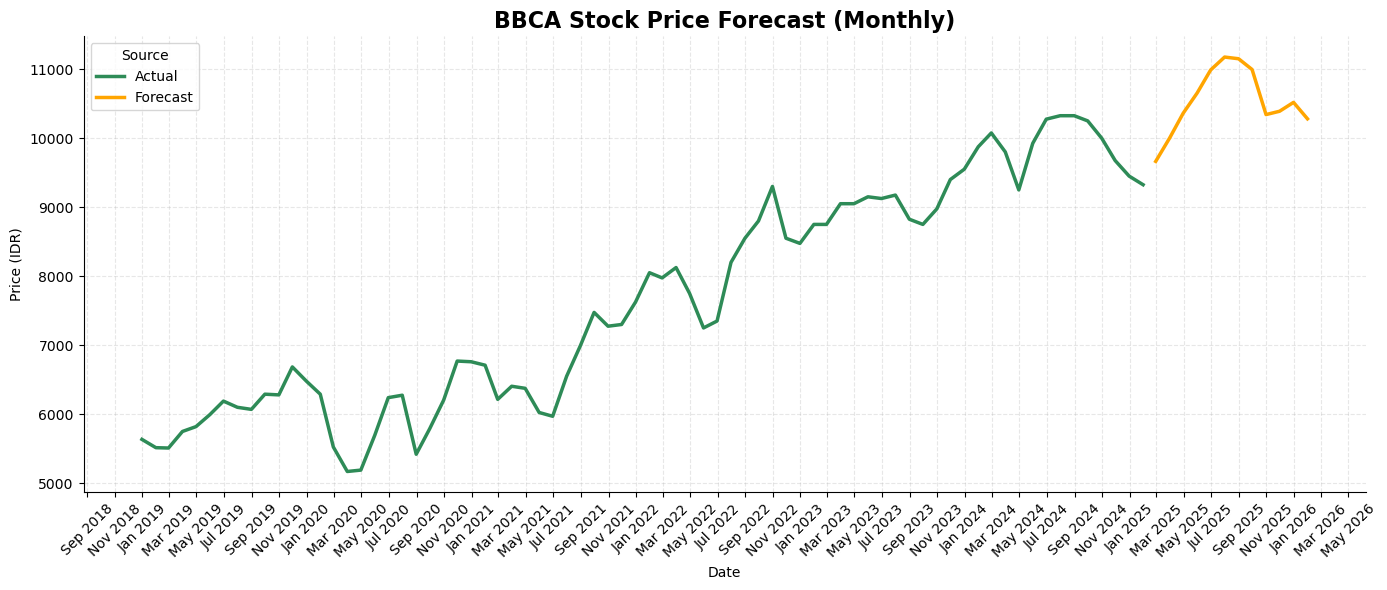

In [21]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns

# Gabung data aktual dan prediksi
plot_df_bbca = pd.concat([
    df[['ds', 'y']].rename(columns={'y': 'Price'}).assign(Source='Actual'),
    pred_df.rename(columns={'TimesNet': 'Price'}).assign(Source='Forecast')
])

# Plot
plt.figure(figsize=(14, 6))
sns.lineplot(
    data=plot_df_bbca,
    x='ds',
    y='Price',
    hue='Source',
    palette=['#2E8B57', '#FFA500'],
    linewidth=2.5
)

# Format tanggal: tampilkan tiap 2 bulan
ax = plt.gca()
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=2))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
plt.xticks(rotation=45)

# Label dan gaya
plt.title('BBCA Stock Price Forecast (Monthly)', fontsize=16, weight='bold')
plt.xlabel('Date')
plt.ylabel('Price (IDR)')
plt.grid(True, linestyle='--', alpha=0.3)
sns.despine()
plt.tight_layout()
plt.show()


# Prediksi Bitcoin 

In [1]:
pip install -U neuralforecast


Note: you may need to restart the kernel to use updated packages.


In [4]:
pip install yfinance

Note: you may need to restart the kernel to use updated packages.


In [2]:
import yfinance as yf
import pandas as pd

# Ambil data Bitcoin bulanan dari Jan 2015 sampai Juni 2025
btc = yf.download('BTC-USD', start='2015-01-01', end='2025-07-01', interval='1mo', auto_adjust=False)

# Bersihkan data
btc = btc.reset_index()[['Date', 'Close']].dropna()
btc.columns = ['ds', 'y']
btc['unique_id'] = 'BTC'

# Cek hasil
print(btc.tail())
print(f"Jumlah bulan: {len(btc)}")


[*********************100%***********************]  1 of 1 completed

            ds              y unique_id
121 2025-02-01   84373.007812       BTC
122 2025-03-01   82548.914062       BTC
123 2025-04-01   94207.312500       BTC
124 2025-05-01  104638.093750       BTC
125 2025-06-01  107135.335938       BTC
Jumlah bulan: 126


In [3]:
btc.head(10)

,ds,y,unique_id
0,2015-01-01,217.464005,BTC
1,2015-02-01,254.263000,BTC
2,2015-03-01,244.223999,BTC
3,2015-04-01,236.145004,BTC
4,2015-05-01,230.190002,BTC
5,2015-06-01,263.071991,BTC
6,2015-07-01,284.649994,BTC
7,2015-08-01,230.056000,BTC
8,2015-09-01,236.059998,BTC
9,2015-10-01,314.165985,BTC


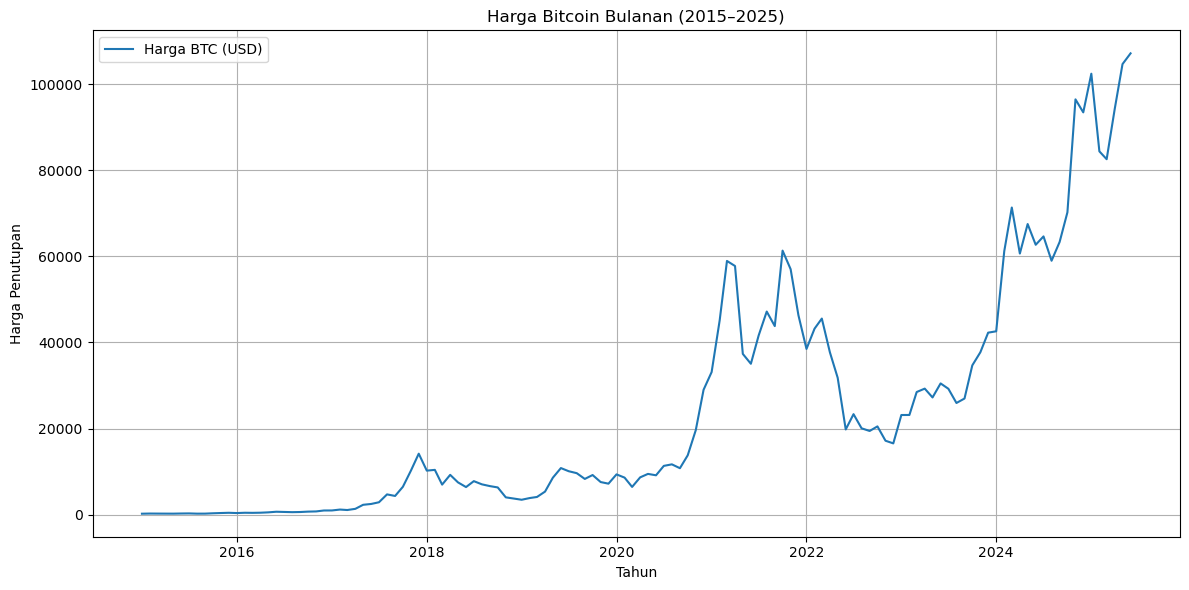

In [4]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,6))
plt.plot(btc['ds'], btc['y'], label='Harga BTC (USD)')
plt.title('Harga Bitcoin Bulanan (2015–2025)')
plt.xlabel('Tahun')
plt.ylabel('Harga Penutupan')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


In [ ]:
from neuralforecast import NeuralForecast
from neuralforecast.models import TimesNet
from neuralforecast.losses.pytorch import MSE

# Konfigurasi TimesNet
model = TimesNet(
    input_size=114,
    h=12,
    loss=MSE(),
    learning_rate=1e-3,
    scaler_type='standard',
    batch_size=32,
    random_seed=42
)

# Inisialisasi NeuralForecast
nf = NeuralForecast(models=[model], freq='M')

# Training model, otomatis split val 10 bulan terakhir
nf.fit(df=btc, val_size=0)


Seed set to 42
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type          | Params | Mode 
---------------------------------------------------------
0 | loss           | MSE           | 0      | train
1 | padder_train   | ConstantPad1d | 0      | train
2 | scaler         | TemporalNorm  | 0      | train
3 | model          | ModuleList    | 4.7 M  | train
4 | enc_embedding  | DataEmbedding | 192    | train
5 | layer_norm     | LayerNorm     | 128    | train
6 | predict_linear | Linear        | 14.5 K | train
7 | projection     | Linear        | 65     | train
---------------------------------------------------------
4.7 M     Trainable params
0         Non-trainable params
4.7 M     Total params
18.809    Total estimated model params size (MB)
50        Modules in train mode
0         Modules in eval mode


Sanity Checking: |                                                                               | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

In [6]:
from neuralforecast import NeuralForecast
from neuralforecast.models import TimesNet

# Konfigurasi model
model = TimesNet(
    input_size=114,
    h=12
)

# Inisialisasi NeuralForecast
nf = NeuralForecast(models=[model], freq='M')  # 'M' untuk bulanan

# Fit ke data
nf.fit(df=btc)

# Prediksi 12 bulan ke depan
forecast = nf.predict()

# Tampilkan hasil
print(forecast)


Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type          | Params | Mode 
---------------------------------------------------------
0 | loss           | MAE           | 0      | train
1 | padder_train   | ConstantPad1d | 0      | train
2 | scaler         | TemporalNorm  | 0      | train
3 | model          | ModuleList    | 4.7 M  | train
4 | enc_embedding  | DataEmbedding | 192    | train
5 | layer_norm     | LayerNorm     | 128    | train
6 | predict_linear | Linear        | 14.5 K | train
7 | projection     | Linear        | 65     | train
---------------------------------------------------------
4.7 M     Trainable params
0         Non-trainable params
4.7 M     Total params
18.809    Total estimated model params size (MB)
50        Modules in train mode
0         Modules in eval mode


Sanity Checking: |                                                                               | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

`Trainer.fit` stopped: `max_steps=1000` reached.
C:\Users\USER\anaconda3\Lib\site-packages\utilsforecast\processing.py:384: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  freq = pd.tseries.frequencies.to_offset(freq)
C:\Users\USER\anaconda3\Lib\site-packages\utilsforecast\processing.py:440: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  freq = pd.tseries.frequencies.to_offset(freq)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |                                                                                    | 0/? [00:00<…

   unique_id         ds       TimesNet
0        BTC 2025-06-30  117558.195312
1        BTC 2025-07-31  119219.640625
2        BTC 2025-08-31  116058.625000
3        BTC 2025-09-30  115775.031250
4        BTC 2025-10-31  118729.148438
5        BTC 2025-11-30  131244.531250
6        BTC 2025-12-31  135842.546875
7        BTC 2026-01-31  144309.968750
8        BTC 2026-02-28  144944.062500
9        BTC 2026-03-31  141228.765625
10       BTC 2026-04-30  147876.578125
11       BTC 2026-05-31  147459.718750


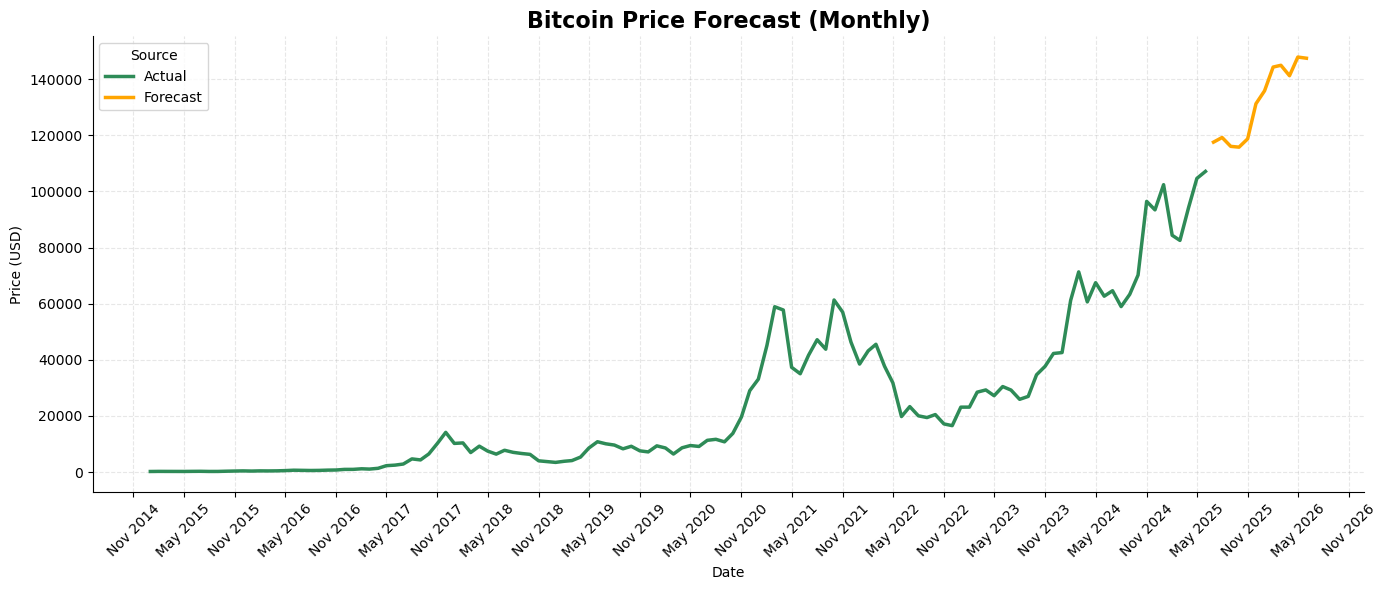

In [15]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns

plt.figure(figsize=(14, 6))

# Plot data
sns.lineplot(
    data=plot_df,
    x='ds',
    y='Price',
    hue='Source',
    palette=['#2E8B57', '#FFA500'],
    linewidth=2.5
)

# Format axis tanggal
ax = plt.gca()
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=6))  # Setiap 6 bulan
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))  # Format: Jan 2025
plt.xticks(rotation=45)

# Label dan judul
plt.title('Bitcoin Price Forecast (Monthly)', fontsize=16, weight='bold')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.grid(True, linestyle='--', alpha=0.3)
sns.despine()
plt.tight_layout()
plt.show()
